# Water Management Single Scenario Analysis

This notebook provides a detailed analysis of a single scenario water allocation simulation. The analysis helps understand how different policies affect:
- Actor behavior and cooperation
- Water allocation and usage
- Economic and ecological impacts

## Setup and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.core as wms
import random
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import seaborn as sns
from types import MethodType

## Policy Definition

Below we define two key policies that regulate water allocation:

1. **Quota Policy**: Determines how much water each actor is allowed to pump
2. **Incentive Policy**: Uses fines and subsidies to influence actor behavior

You can modify these policies to test different regulation strategies.

## Simulation Configuration and Execution

Now we'll configure and run the simulation with our defined policies:

In [2]:
from src.optim import EvolutionnarySearch
from src.policies.custom_linear_evol_policies import tuned_generate_individuals_for_linear, tuned_make_linear_incentive_function, tuned_make_linear_quota_function

# If you want a single execution with optimal values set to True
# Otherwise it will execute a whole EvolutionnarySearch wich can take up to several hours
USE_PRETRAINED_VALUES = True
# Set the scenario here to enable automatic best params selection 
SCENARIO = "0.yml"

# These are the best parameters obtained after EvolutionnarySearch
scenario_0_best_ind = {
    "PF": 1.4342356535532237,
    "PG": 0.6662408429966779,
    "WF_EF": 0.5104268591566881,
    "PUR": 0.3402569495351941,
    "SUB_BC" : 1.9762293986536237,
    "FIN_BC" : 0.17021769764908726,
    "WF_SF": 8.126357459692112,
    "ANT_C_F": 0.4585625212587976,
    "ANT_N_F": 0.2716974474707285,
    "CF": 1.994113079871528,
    "CG": 0.2723421170311795
}

scenario_1_best_ind = {
    "PF":1.3714379827600525,
    "PG":7.154471999587505,
    "WF_EF":0.4214744283977393,
    "PUR":0.6755029716107883,
    "SUB_BC" :0.7860125188217294,
    "FIN_BC" : 0.11158330598535778,
    "WF_SF":7.700511187509747,
    "ANT_C_F":-0.1579986566700551,
    "ANT_N_F":0.6969863696527481,
    "CF":1.5100765416314796,
    "CG":0.5769929397796756
}


yaml_path = f"parameters/scenarios/{SCENARIO}"  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 500        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  # Uncertainty in forecasts
# Initialize and run simulation
simulation = wms.WaterManagementSimulation(**params)

N_GEN = 2

search = EvolutionnarySearch(
    simulation=simulation,
    p_best_parents=2,
    pop_size=2,
    n_gen=N_GEN,
    mutation_rate=0.8, # Only 40% of genes will mutate at each generation, the less it is, the more stable evolution will be
    initial_mutation_spread=1, # Mutation will follow a random mutation (increase or decrease) in a normally distributed factor centered around 1, with your desired standard deviation (the bigger it gets, the bigger changes will be)  
    ecol_weight=1.1, # Focus a bit more on ecological impact
    econ_weight=1,
)

search.make_incentive_function = MethodType(tuned_make_linear_incentive_function, search)
search.make_quota_function = MethodType(tuned_make_linear_quota_function, search)
search.generate_individuals = MethodType(tuned_generate_individuals_for_linear, search)

if USE_PRETRAINED_VALUES:
    if SCENARIO == "0.yml":
        optimized_incentive = search.make_incentive_function(scenario_0_best_ind)
        optimized_quota = search.make_quota_function(scenario_0_best_ind)
    else:
        optimized_incentive = search.make_incentive_function(scenario_1_best_ind)
        optimized_quota = search.make_quota_function(scenario_1_best_ind)

    # Apply our custom policies
    simulation.incentive_policy = MethodType(optimized_incentive, simulation)
    simulation.compute_actor_quota = MethodType(optimized_quota, simulation)
    
    # Run the simulation
    simulation.run_simulation()
else:
    execution_results = search.run_search()
    best_result = search.get_best_result()
    simulation = best_result["simulation"]



# Get final performance scores
ecological_impact, economic_impact, ok_satisfaction = simulation.get_final_scores_scaled()

print(f"Simulation complete. Final scores:")
print(f"Ecological Impact: {ecological_impact:.4f} (lower is better)")
print(f"Economic Impact: {economic_impact:.4f} (higher is better)")

# Prepare for visualization
sns.set(style='whitegrid')
cmap = plt.get_cmap('Dark2')
actors_colors = [cmap(i) for i in range(simulation.nb_actors)]
x_values = range(params["total_turns"])

High satisfaction: 0.8048120107397121 Medium satisfaction: 0.8041479698842651 Low satisfaction: 0.8008157240836781
Simulation complete. Final scores:
Ecological Impact: 0.8627 (lower is better)
Economic Impact: 0.1339 (higher is better)


## 0. EvolutionnarySearch Results

In [3]:
import plotly.express as px
import pandas as pd

if not USE_PRETRAINED_VALUES:

    incentive_data = [row['params'] for row in execution_results]
    # quota_data = [row['quota_params'] for row in execution_results]
    ecological_impact = [row['ecological_impact'] for row in execution_results]
    economic_impact = [row['economic_impact'] for row in execution_results]
    h_satisfaction_data = {}
    m_satisfaction_data = {}
    l_satisfaction_data = {}
    h_satisfaction_data["h_s"] = [row['high_sat'] for row in execution_results]
    m_satisfaction_data["m_s"] = [row['med_sat'] for row in execution_results]
    l_satisfaction_data["l_s"] = [row['low_sat'] for row in execution_results]
    gen_data = {}
    gen_data["generation"] = [row['generation'] for row in execution_results]

    df_gen = pd.DataFrame(gen_data)
    df_incentive = pd.DataFrame(incentive_data)
    # df_quota = pd.DataFrame(quota_data)
    df_satisfaction_h = pd.DataFrame(h_satisfaction_data)
    df_satisfaction_m = pd.DataFrame(m_satisfaction_data)
    df_satisfaction_l = pd.DataFrame(l_satisfaction_data)
    df_impact = pd.DataFrame({
        "ecol": ecological_impact,
        "econ": economic_impact
    })

    df = pd.concat([df_gen,
                    df_incentive,
                    df_impact,
                    df_satisfaction_h,
                    df_satisfaction_m,
                    df_satisfaction_l,
                    ], axis=1)

    fig = px.parallel_coordinates(
        df,
        color="generation",
        dimensions=df.columns,
        color_continuous_scale=px.colors.diverging.Temps,
        color_continuous_midpoint=N_GEN/2
    )

    fig.show()

    med_sat = df["l_s"] > df["m_s"]
    high_sat = df["h_s"] > df["m_s"]
    comb = high_sat == med_sat
    econ_pos = df["econ"] > -0.5

    fig = px.parallel_coordinates(
        df[econ_pos],
        color="generation",
        dimensions=df.columns,
        color_continuous_scale=px.colors.diverging.Temps,
        color_continuous_midpoint=N_GEN/2,
    )

    fig.show()


## 1. Water Resource Analysis

First, let's examine the water resource availability throughout the simulation period and how it relates to actor demands.

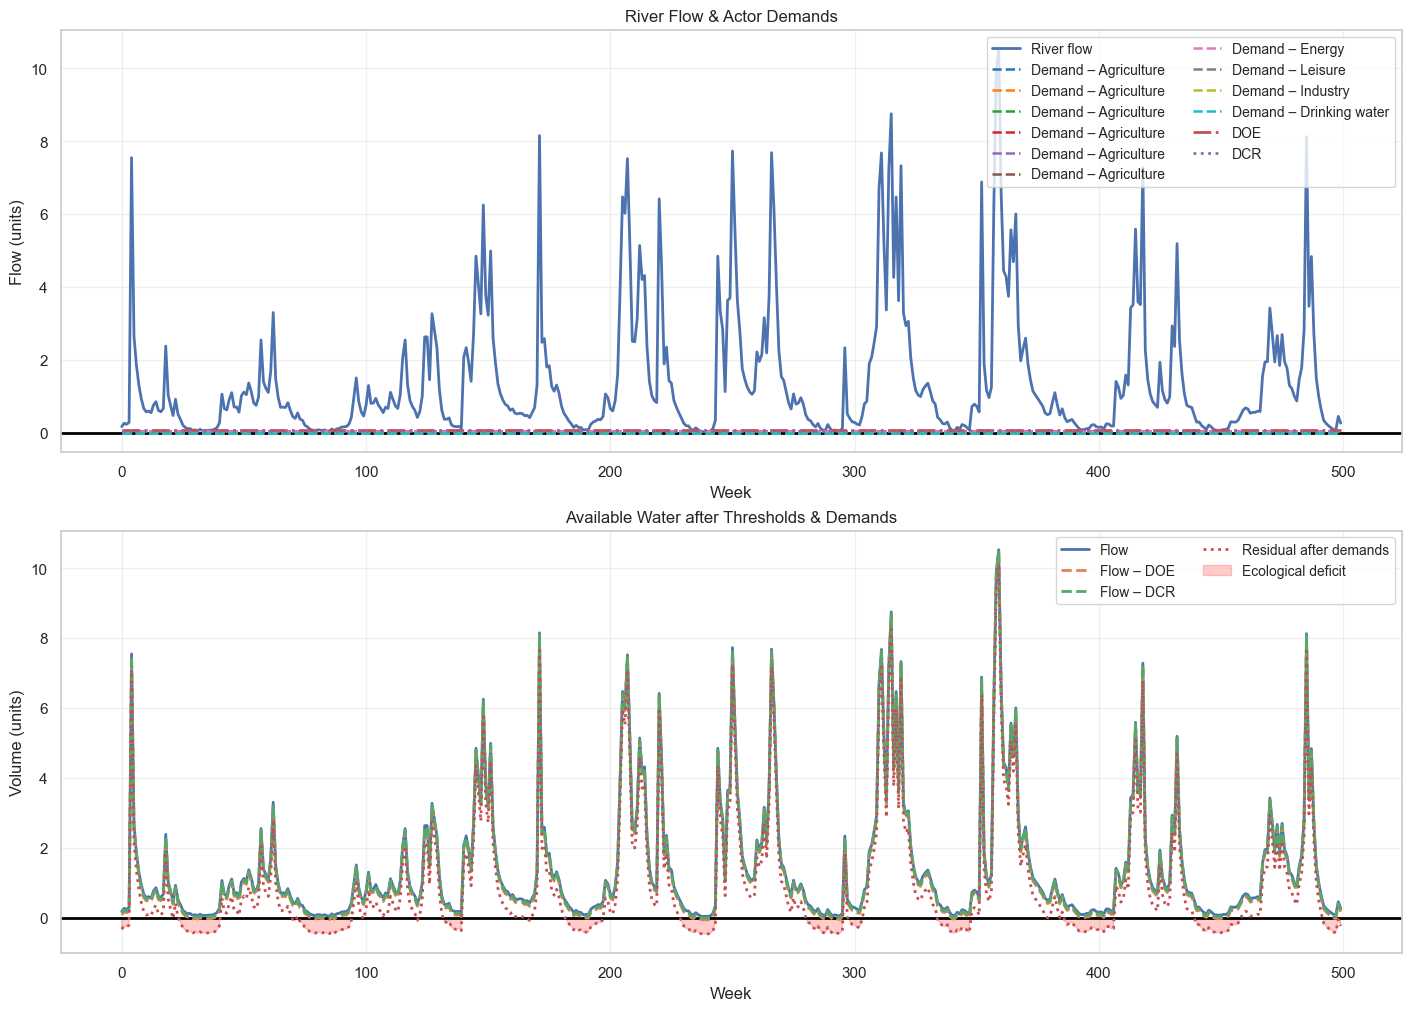

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot river flow
gtp.plot_river_flow(axes[0], x_values, simulation)

# Plot remaining water after ecological threshold
gtp.plot_remaining_water(axes[1], x_values, simulation)

plt.show()

### Analysis of Water Resources

The top graph shows the raw river flow over time, along with each actor's water demand and the ecological threshold (DCR). The total demand line shows the sum of all actor demands.

The bottom graph shows the remaining water available for allocation after respecting the ecological threshold. When this line drops below zero (red shaded areas), it indicates periods where fulfilling all demands would breach the minimum environmental flow requirements.

## 2. Actor Behavior and Crisis Response

Now, let's analyze how actors behave in response to changing water availability and crisis levels.

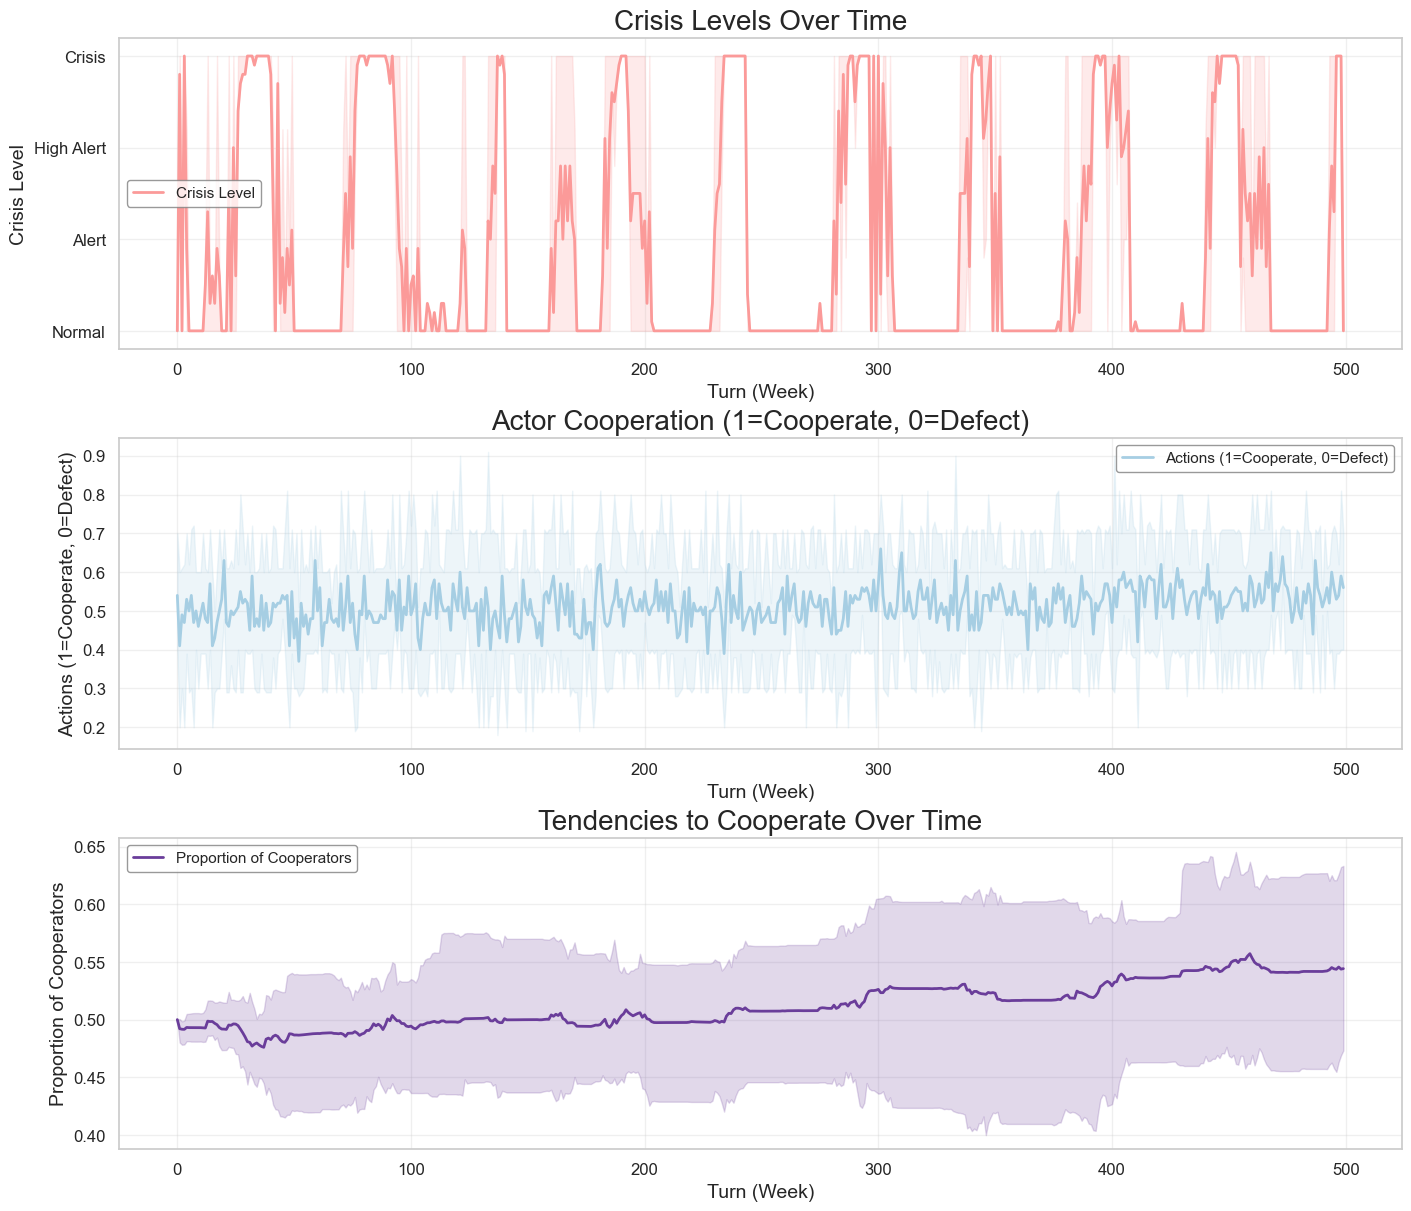

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot crisis levels
gtp.plot_data(axes[0], x_values, simulation, "w_crisis", mode="mean")
axes[0].set_title('Crisis Levels Over Time', fontsize=20)
axes[0].set_ylim(-1.2, 2.2)
axes[0].set_yticks([-1, 0, 1, 2])
axes[0].set_yticklabels(['Normal', 'Alert', 'High Alert', 'Crisis'])

# Plot actor cooperation actions
gtp.plot_data(axes[1], x_values, simulation, "h_actions", mode="mean")
axes[1].set_title('Actor Cooperation (1=Cooperate, 0=Defect)', fontsize=20)

# Plot tendencies to cooperate
gtp.plot_data(axes[2], x_values, simulation, "h_tendencies", mode="mean")
axes[2].set_title('Tendencies to Cooperate Over Time', fontsize=20)

plt.show()

### Analysis of Actor Behavior

These graphs reveal how actors respond to crisis situations:

- The **Crisis Level** graph shows when the system enters different states of water stress.
- The **Actor Cooperation** graph shows actors' decisions to either cooperate (1) or defect (0).
- The **Tendencies to Cooperate** graph shows the evolving probability of cooperation for each actor.

Notice how cooperation tendencies change in response to crisis events. This reveals how actors learn from experience and adapt their strategies based on outcomes.

## 3. Water Allocation and Economic Outcomes

Next, let's examine how water is allocated among actors and its economic impacts.

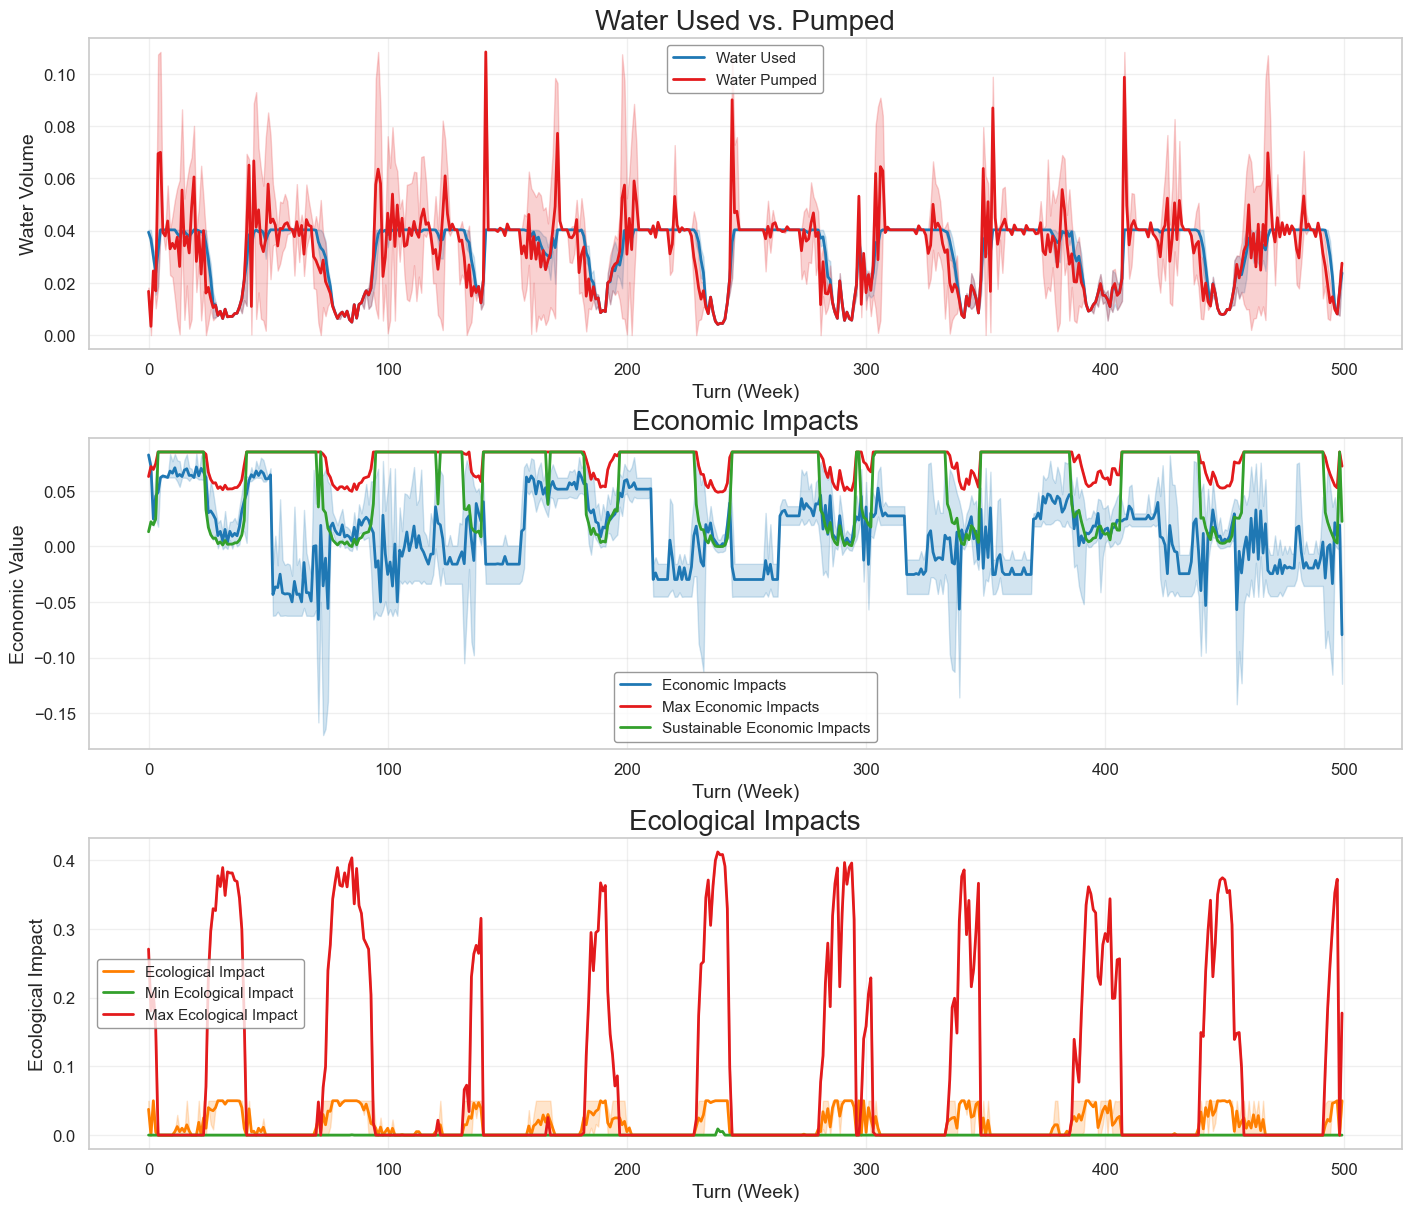

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot water usage
gtp.compare_data(
    axes[0], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Water Volume',
    title='Water Used vs. Pumped'
)

# Plot economic impacts
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Economic Value',
    title='Economic Impacts'
)

# Plot ecological impacts
gtp.compare_data(
    axes[2], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Ecological Impact',
    title='Ecological Impacts'
)

plt.show()

### Analysis of Allocation and Impacts

These graphs show the outcomes of the water allocation process:

- **Water Used vs. Pumped**: Compares water pumped from the river to water actually used. The difference goes into storage.
- **Economic Impacts**: Shows the actual economic value generated compared to theoretical maximum and sustainable minimum values.
- **Ecological Impacts**: Shows the environmental impact of water usage compared to minimum and maximum possible impacts.

These metrics help evaluate how well the policy balances economic benefits against ecological integrity.

## 4. Policy Effectiveness Analysis

Now let's analyze how the incentive policy (fines and subsidies) influenced actor behavior.

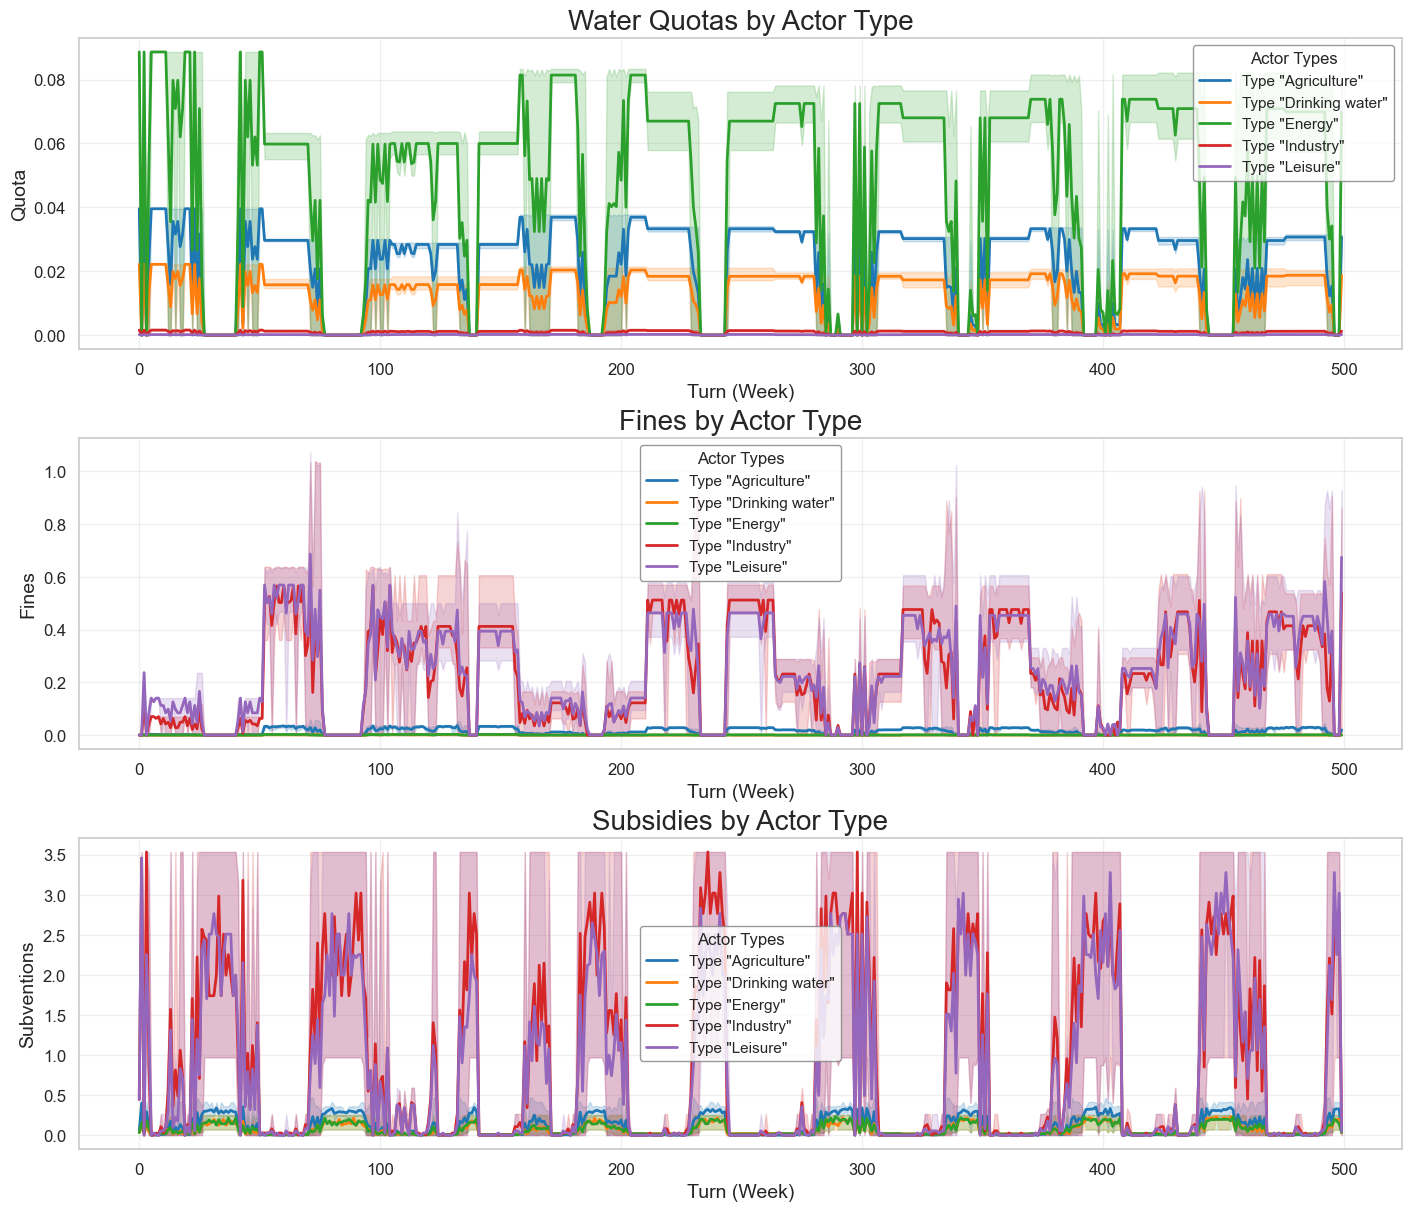

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot quotas by actor type
gtp.plot_actor_data_by_type(axes[0], x_values, simulation, "h_quota", mode="actors_mean")
axes[0].set_title('Water Quotas by Actor Type', fontsize=20)

# Plot fines and subsidies 
gtp.plot_actor_data_by_type(axes[1], x_values, simulation, "h_fines", mode="actors_mean")
axes[1].set_title('Fines by Actor Type', fontsize=20)

gtp.plot_actor_data_by_type(axes[2], x_values, simulation, "h_subventions", mode="actors_mean")
axes[2].set_title('Subsidies by Actor Type', fontsize=20)

plt.show()

### Analysis of Policy Interventions

These graphs reveal how the incentive policy worked:

- **Water Quotas**: Shows the allowed water allocation for each actor type over time.
- **Fines**: Shows penalties applied when actors exceeded their quotas.
- **Subsidies**: Shows incentives given to encourage cooperation.

The effectiveness of these tools can be evaluated by comparing them to the cooperation tendencies seen earlier.

## 5. Cumulative Impact Analysis

Finally, let's examine the cumulative impacts over the entire simulation period.

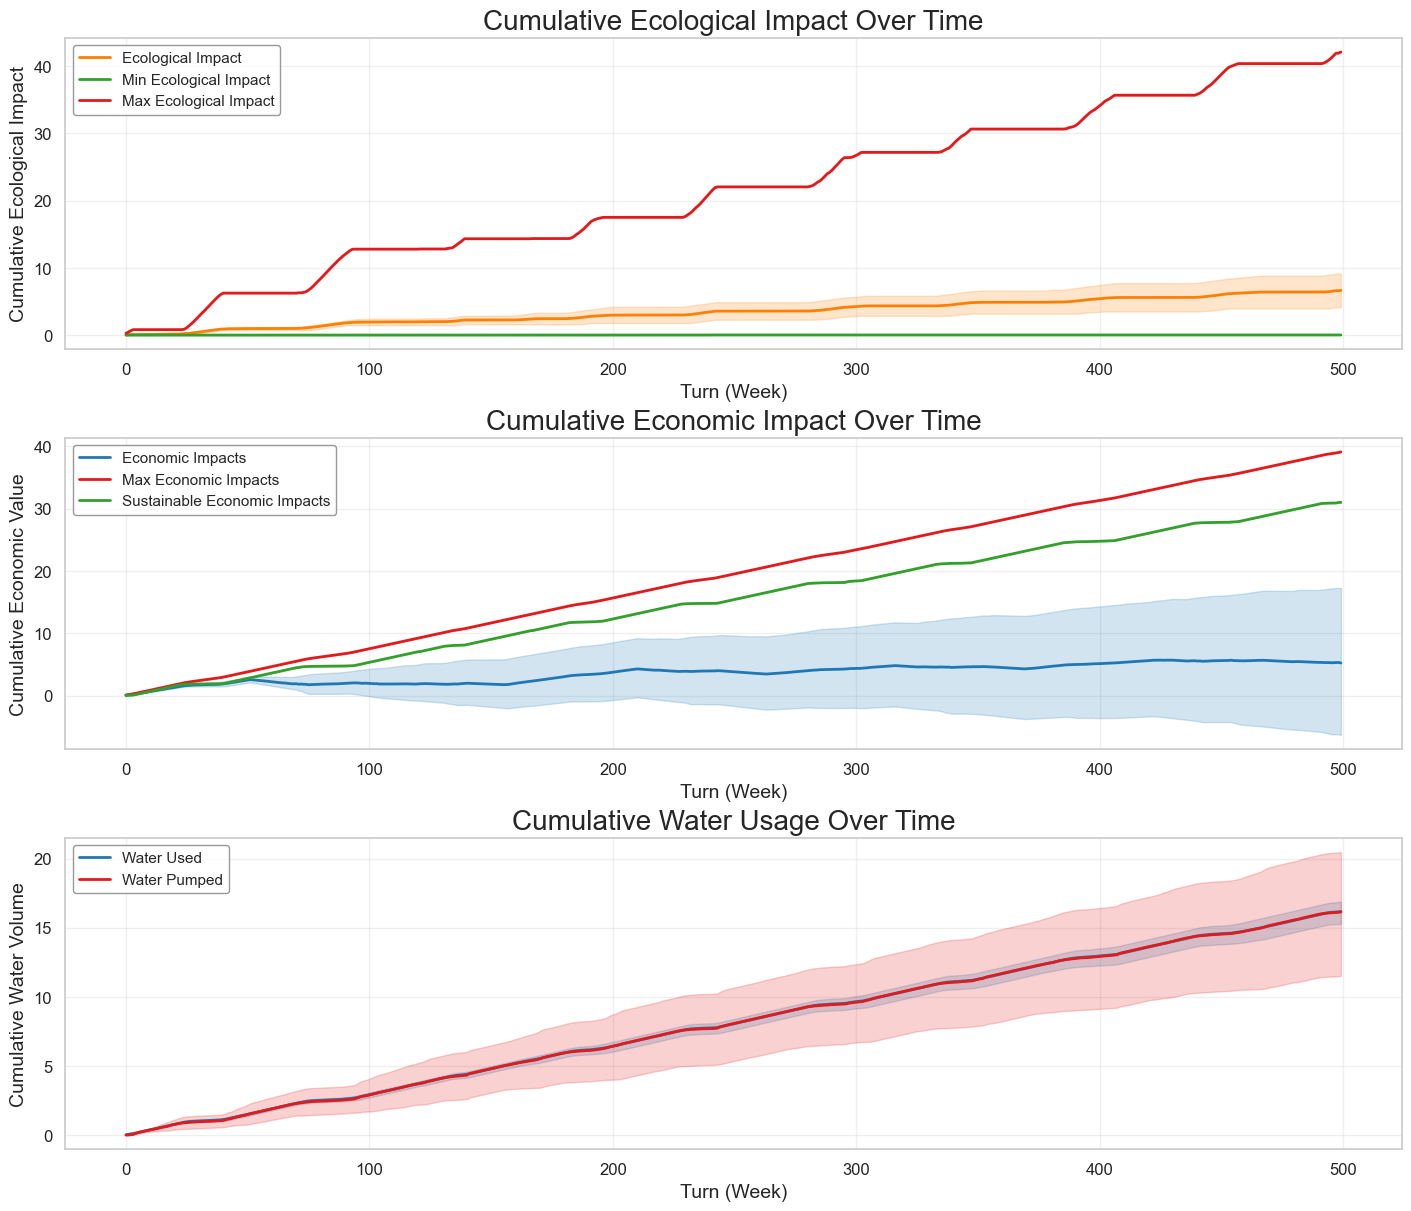

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Cumulative ecological impact
gtp.compare_data(
    axes[0], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Ecological Impact',
    title='Cumulative Ecological Impact Over Time',
    cumulative=True
)

# Cumulative economic impact
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Economic Value',
    title='Cumulative Economic Impact Over Time',
    cumulative=True
)

# Cumulative water usage
gtp.compare_data(
    axes[2], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Water Volume',
    title='Cumulative Water Usage Over Time',
    cumulative=True
)

plt.show()

### Analysis of Cumulative Impacts

These graphs show the long-term, cumulative outcomes of the policy:

- **Cumulative Ecological Impact**: Shows the total environmental impact over time.
- **Cumulative Economic Impact**: Shows the total economic value generated over time.
- **Cumulative Water Usage**: Shows the total water pumped and used over time.

These cumulative metrics are useful for evaluating the overall performance of the policy across the entire simulation period.

## 6. Actor-Specific Analysis

For a deeper understanding, let's examine how individual actors behaved.

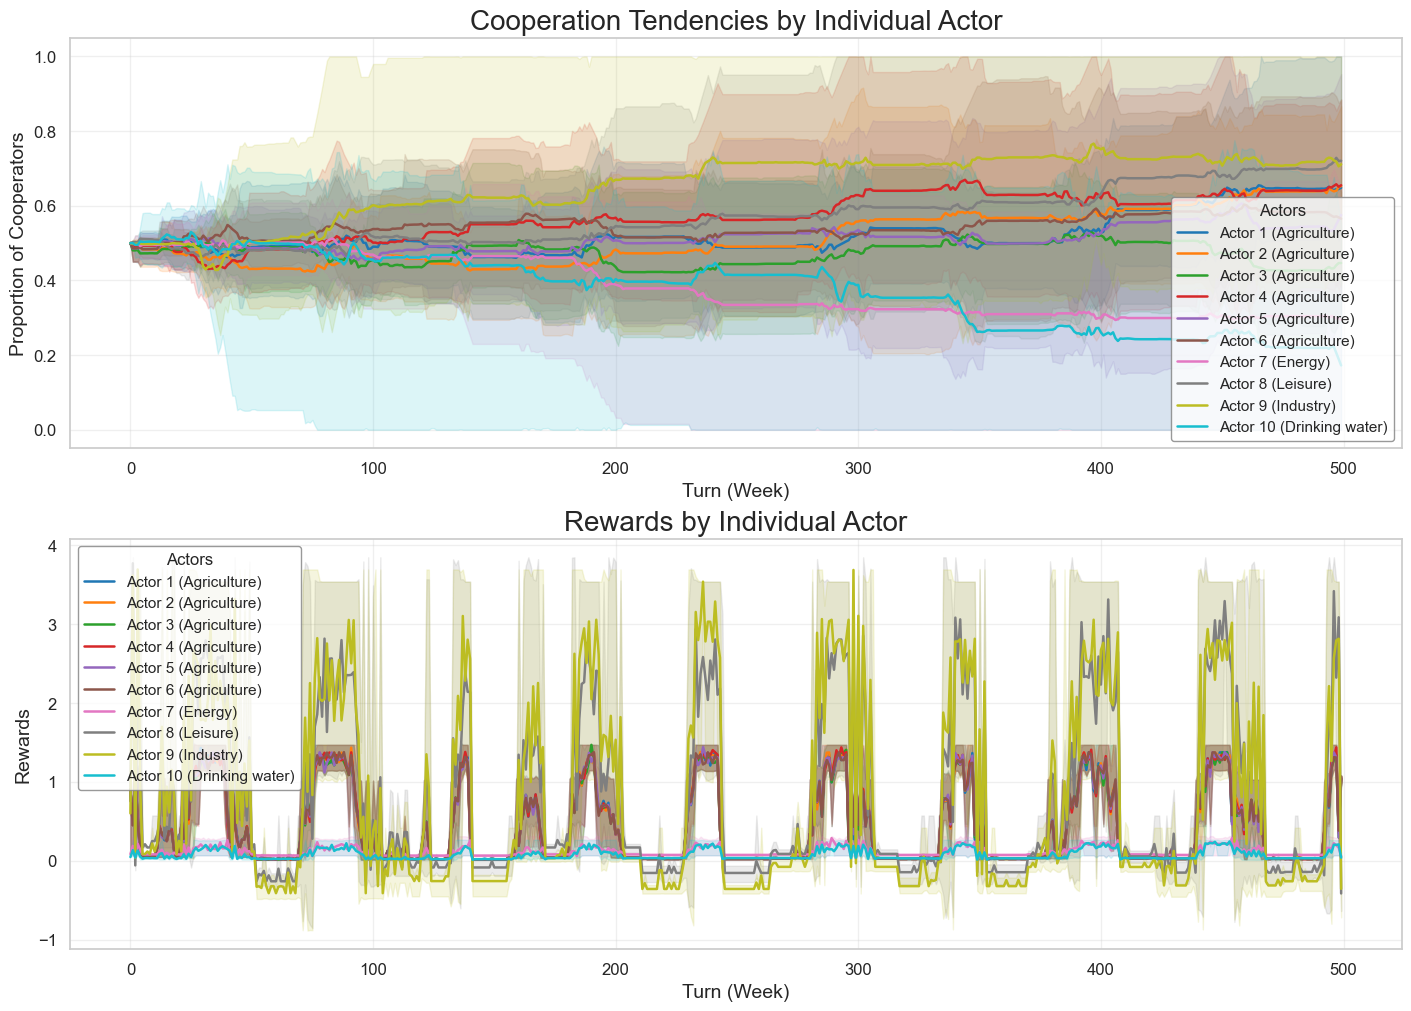

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot cooperation tendencies for individual actors
gtp.plot_actor_data(axes[0], x_values, simulation, "h_tendencies")
axes[0].set_title('Cooperation Tendencies by Individual Actor', fontsize=20)

# Plot rewards for individual actors
gtp.plot_actor_data(axes[1], x_values, simulation, "h_rewards")
axes[1].set_title('Rewards by Individual Actor', fontsize=20)

plt.show()

### Analysis of Individual Actor Behavior

These graphs provide actor-specific insights:

- **Cooperation Tendencies**: Shows how each individual actor's tendency to cooperate evolved over time.
- **Rewards**: Shows the economic rewards received by each actor.

Notice how different actors may have different strategies based on their priority, demand, and other characteristics.

## Conclusion

This analysis demonstrates how water allocation policies can influence actor behavior and overall system outcomes. The key insights are:

1. Water scarcity triggers crisis situations that require cooperation to manage effectively
2. Actors adapt their behavior based on incentives and outcomes
3. Policies must balance economic benefits against ecological integrity
4. Different actor types respond differently to incentives based on their priorities and needs

By testing different policy settings in this simulation, you can develop more effective water management strategies that promote cooperation while maintaining environmental flows.

## Next Steps

To further improve the policy, consider:

1. Adjusting quota calculations based on precise water availability
2. Fine-tuning incentive levels to better influence cooperation
3. Testing different policy combinations under various scarcity scenarios
4. Adding additional mechanisms like water trading or resource pooling